# Импорт библиотек

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  LogisticRegression, Ridge, SGDClassifier)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   PolynomialFeatures, StandardScaler)

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from sklearn.model_selection import KFold

```
sklearn.__version__
0.20.2
```

# Загрузка данных

In [43]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')
y = train['Survived']
test = pd.read_csv('data/test.csv', index_col='PassengerId')

In [44]:
print(train.shape)
train.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
print(test.shape)
test.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Имена

In [46]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')

kf = KFold(n_splits=3, shuffle=True)
for train_idx, test_idx in kf.split(train):
    X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
    
    nnn = X_train[['Survived']].copy()
    nnn['last_name'] = X_train['Name'].str.split(",", expand=True)[0]
    ln_survived = list(nnn.query('Survived == 1')['last_name'].unique())
    ln_unsurvived = list(nnn.query('Survived == 0')['last_name'].unique())
    
    train.loc[X_test.index,'ln_survived'] = X_test['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)
    train.loc[X_test.index,'ln_unsurvived'] = X_test['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)

In [47]:
nnn = train[['Survived']].copy()
nnn['last_name'] = train['Name'].str.split(",", expand=True)[0]
ln_survived = list(nnn.query('Survived == 1')['last_name'].unique())
ln_unsurvived = list(nnn.query('Survived == 0')['last_name'].unique())

test['ln_survived'] = test['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)
test['ln_unsurvived'] = test['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)

# Preproc

In [31]:
def preproc(df):
    df['Sex'] = df['Sex'].map({'male':0,'female':1})
    
    df['Mr'] = df['Name'].str.contains('Mr\.').astype(int)
    df['Miss'] = df['Name'].str.contains('Miss\.').astype(int)
    df['Mrs'] = df['Name'].str.contains('Mrs\.').astype(int)
    df['Master'] = df['Name'].str.contains('Master\.').astype(int)
    df['Jr'] = df['Name'].str.contains(' Jr').astype(int)
    #df['the'] = df['Name'].str.contains(' the').astype(int)
    #df['of'] = df['Name'].str.contains(' of').astype(int)
    #df['Dr'] = df['Name'].str.contains('Dr\.').astype(int)
    #df['Rev'] = df['Name'].str.contains('Rev\.').astype(int)
    
    df['()'] = df['Name'].str.contains('[(*)]').astype(int)
    df['""'] = df['Name'].str.contains('["*"]').astype(int)
    
    #df['ln_survived'] = df['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)
    #df['ln_unsurvived'] = df['Name'].str.split(",", expand=True)[0].apply(lambda x: 1 if x in ln_survived else 0)
    
    df['Name_len'] = df['Name'].str.len()
    
    df['Age_null'] = df['Age'].isna().astype(int)
    df['Cabin_null'] = df['Cabin'].isna().astype(int)
    
    df['Cabin_num_len'] = df['Cabin'].str.findall('(\d+)').dropna().apply(lambda l: len(l)).fillna(0)
    df['Cabin_num'] = df['Cabin'].str.findall('(\d+)').dropna().apply(lambda l: np.array([int(i) for i in l]).mean())
    df['Cabin_char'] = df['Cabin'].str.findall('[A-Za-z]').dropna().apply(lambda l: l[-1])
    
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().index[0])
    
    df = pd.get_dummies(df, columns = ['Pclass'])
    df = pd.get_dummies(df, columns = ['Embarked'])
    df = pd.get_dummies(df, columns = ['Cabin_char'])
    df['Age_rnd'] = (df['Age'] / 10).round()
    df = pd.get_dummies(df, columns = ['Age_rnd'])
    
    df['Cabin_num_len'] = df['Cabin_num_len'].fillna(-100)
    df['Cabin_num'] = df['Cabin_num'].fillna(-100)
    df['Age'] = df['Age'].fillna(-100)
    
    drop_cols = ['Name','Ticket','Pclass','Embarked','Cabin','Cabin_char','Age_rnd','Cabin_char_T','Survived']
    cols = [col for col in df.columns if col not in drop_cols]
    
    return df[cols]

In [48]:
#train = pd.read_csv('data/train.csv', index_col='PassengerId')
#y = train['Survived']
#test = pd.read_csv('data/test.csv', index_col='PassengerId')

train = preproc(train)
test = preproc(test)
test = test[train.columns]

/opt/python3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.


In [49]:
train

,Sex,Age,SibSp,Parch,Fare,ln_survived,ln_unsurvived,Mr,Miss,Mrs,...,Cabin_char_G,Age_rnd_0.0,Age_rnd_1.0,Age_rnd_2.0,Age_rnd_3.0,Age_rnd_4.0,Age_rnd_5.0,Age_rnd_6.0,Age_rnd_7.0,Age_rnd_8.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0.0,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,38.0,1,0,71.2833,0.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,26.0,0,0,7.9250,0.0,0.0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,35.0,1,0,53.1000,0.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,0,35.0,0,0,8.0500,0.0,0.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,-100.0,0,0,8.4583,1.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,54.0,0,0,51.8625,0.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,2.0,3,1,21.0750,0.0,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,1,27.0,0,2,11.1333,1.0,1.0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [41]:
test

,Sex,Age,SibSp,Parch,Fare,Mr,Miss,Mrs,Master,Jr,...,Cabin_char_G,Age_rnd_0.0,Age_rnd_1.0,Age_rnd_2.0,Age_rnd_3.0,Age_rnd_4.0,Age_rnd_5.0,Age_rnd_6.0,Age_rnd_7.0,Age_rnd_8.0
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,34.5,0,0,7.8292,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
893,1,47.0,1,0,7.0000,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
894,0,62.0,0,0,9.6875,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
895,0,27.0,0,0,8.6625,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
896,1,22.0,1,1,12.2875,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
897,0,14.0,0,0,9.2250,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
898,1,30.0,0,0,7.6292,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
899,0,26.0,1,1,29.0000,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
900,1,18.0,0,0,7.2292,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


# RandomizedSearchCV

In [53]:
params = {    
    'poly__degree': [2,3,4],
    'selection__max_features': range(1,20),
    'logistic__penalty': ['l1','l2'],
    #'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'logistic__max_iter': range(10,1000),
    'logistic__C': np.logspace(-8, 8, 200)
    #'logistic__tol': [0.005, 0.0001, 0.0005]
}

num_cols = ['Fare','Cabin_num','Age','Name_len','SibSp','Parch','Cabin_num_len']

poly = PolynomialFeatures()
scaler = MinMaxScaler() #StandardScaler() MinMaxScaler()
logistic = LogisticRegression()
selection_model = RandomForestClassifier(random_state=42)

pipe = Pipeline(steps=[
    #('preprocessor', preprocessor),
    ('poly', poly),
    ('selection', SelectFromModel(selection_model)),
    ('scaler', scaler),
    ('logistic', logistic)
])

search = RandomizedSearchCV(
    pipe, params, n_iter=1000, scoring='accuracy', n_jobs=30, cv=3, random_state=42, verbose=5)
search.fit(train, y)

print(search.best_score_)
print(search.best_params_)
#print(train.columns[search.best_estimator_.named_steps['selection'].get_support()])

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 196 tasks      | elapsed:   37.2s
[Parallel(n_jobs=30)]: Done 369 tasks      | elapsed:   54.4s
[Parallel(n_jobs=30)]: Done 539 tasks      | elapsed:  1.4min
[Parallel(n_jobs=30)]: Done 737 tasks      | elapsed:  1.8min
[Parallel(n_jobs=30)]: Done 971 tasks      | elapsed:  2.4min
[Parallel(n_jobs=30)]: Done 1241 tasks      | elapsed:  3.1min
[Parallel(n_jobs=30)]: Done 1547 tasks      | elapsed:  3.8min
[Parallel(n_jobs=30)]: Done 1889 tasks      | elapsed:  4.6min
[Parallel(n_jobs=30)]: Done 2267 tasks      | elapsed:  5.6min
[Parallel(n_jobs=30)]: Done 2681 tasks      | elapsed:  6.6min
[Parallel(n_jobs=30)]: Done 3000 out of 3000 | elapsed:  7.3min finished


0.8114478114478114
{'selection__max_features': 19, 'poly__degree': 3, 'logistic__penalty': 'l1', 'logistic__max_iter': 106, 'logistic__C': 0.9115888299750818}


/opt/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [54]:
sub = test[[]].copy()
sub['Survived'] = search.predict(test)
sub.to_csv('titanic_sub/sub38.csv')

# EDA

In [29]:
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')

## NULL

In [129]:
temp = train.isna().sum().sort_values(ascending=False).rename('null_cnt').to_frame()
temp['%'] = (train.isna().mean()*100).round(2)
temp.index.name = 'column'
temp

,null_cnt,%
column,,
Cabin_char,687,77.10
Age,177,19.87
Cabin_num,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Fare,0,0.00
Embarked,0,0.00
Mr,0,0.00


In [130]:
temp = test.isna().sum().sort_values(ascending=False).rename('null_cnt').to_frame()
temp['%'] = (test.isna().mean()*100).round(2)
temp.index.name = 'column'
temp

,null_cnt,%
column,,
Cabin_char,327,78.23
Age,86,20.57
Cabin_num,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Fare,0,0.00
Embarked,0,0.00
Mr,0,0.00


## Survived

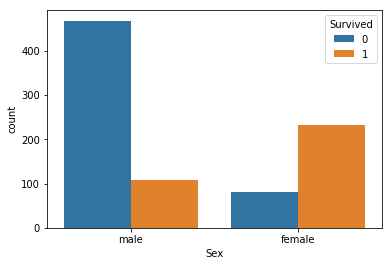

In [12]:
sns.countplot(data=train, x='Sex', hue='Survived');

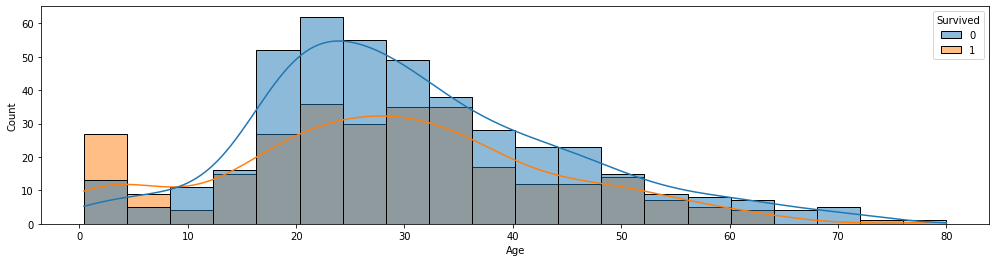

In [11]:
plt.figure(figsize=(17,4))
sns.histplot(data=data, x='Age', hue='Survived', kde=True);

## Age

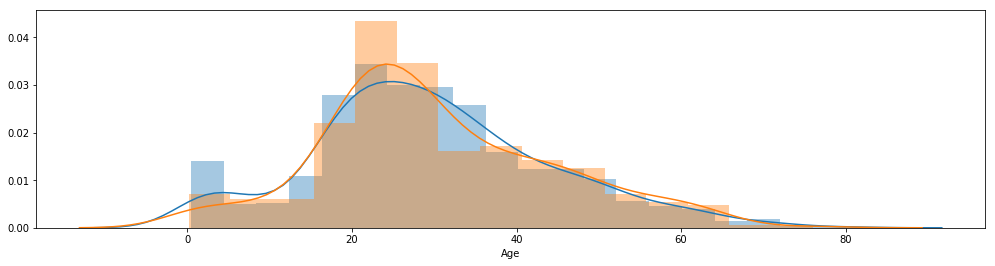

In [19]:
plt.figure(figsize=(17,4))
sns.distplot(train['Age'].dropna());
sns.distplot(test['Age'].dropna());

In [20]:
train.groupby('Survived')['Age'].agg(['mean', 'median'])

,mean,median
Survived,,
0,30.626179,28.0
1,28.343690,28.0


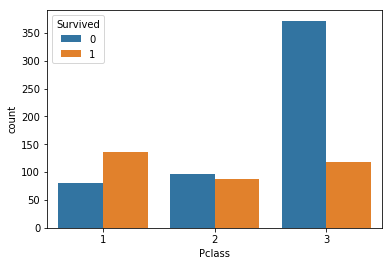

In [22]:
sns.countplot(data=train, x='Pclass', hue='Survived');

## Embarked

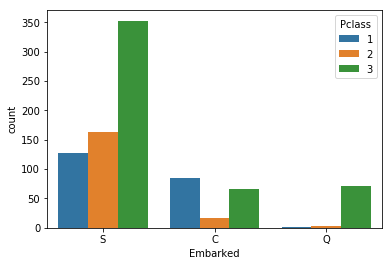

In [23]:
sns.countplot(data=train, x='Embarked', hue='Pclass');

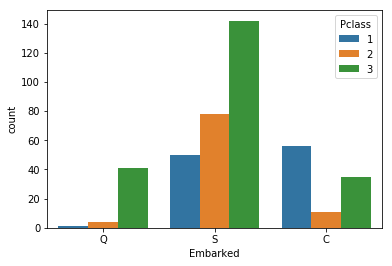

In [24]:
sns.countplot(data=test, x='Embarked', hue='Pclass');

## Pclass

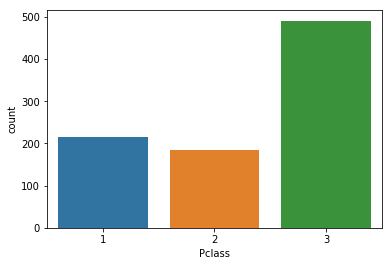

In [25]:
sns.countplot(data=train, x='Pclass');

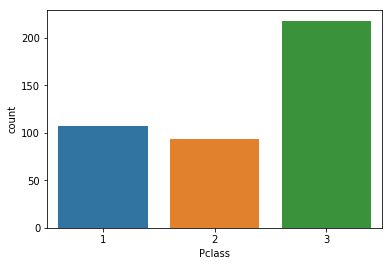

In [26]:
sns.countplot(data=test, x='Pclass');

## Sex

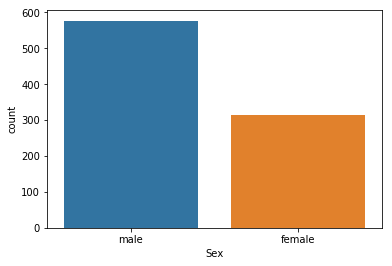

In [27]:
sns.countplot(data=train, x='Sex');

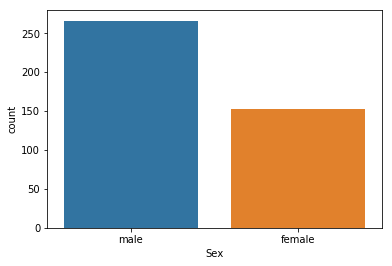

In [28]:
sns.countplot(data=test, x='Sex');

## Name

In [43]:
for n in train['Name'].values:
    print(n)

Braund, Mr. Owen Harris
Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Heikkinen, Miss. Laina
Futrelle, Mrs. Jacques Heath (Lily May Peel)
Allen, Mr. William Henry
Moran, Mr. James
McCarthy, Mr. Timothy J
Palsson, Master. Gosta Leonard
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
Nasser, Mrs. Nicholas (Adele Achem)
Sandstrom, Miss. Marguerite Rut
Bonnell, Miss. Elizabeth
Saundercock, Mr. William Henry
Andersson, Mr. Anders Johan
Vestrom, Miss. Hulda Amanda Adolfina
Hewlett, Mrs. (Mary D Kingcome) 
Rice, Master. Eugene
Williams, Mr. Charles Eugene
Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)
Masselmani, Mrs. Fatima
Fynney, Mr. Joseph J
Beesley, Mr. Lawrence
McGowan, Miss. Anna "Annie"
Sloper, Mr. William Thompson
Palsson, Miss. Torborg Danira
Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)
Emir, Mr. Farred Chehab
Fortune, Mr. Charles Alexander
O'Dwyer, Miss. Ellen "Nellie"
Todoroff, Mr. Lalio
Uruchurtu, Don. Manuel E
Spencer, Mrs. William Augustus (Marie E

In [31]:
train['Name'].str.split(expand=True).stack().value_counts()

Mr.            517
Miss.          182
Mrs.           125
William         62
John            44
Master.         40
Henry           33
James           24
Charles         23
George          22
Thomas          21
Edward          18
Joseph          16
Frederick       15
Johan           15
Samuel          13
Arthur          13
Mary            13
Richard         13
Alfred          12
Anna            11
Jr              10
Elizabeth        9
Peter            9
Andersson,       9
Karl             9
Robert           9
Ernest           9
Alexander        9
Albert           8
              ... 
Torborg          1
Aloisia          1
Fiske            1
Bradley          1
Albimona,        1
Porter,          1
Beard            1
Elias)           1
Drake            1
Moraweck,        1
Celotti,         1
Homer,           1
LeRoy,           1
Danielsen        1
Linus            1
(Alma            1
Strandberg,      1
Briggs           1
Connaghton,      1
Torber,          1
Smiljanic,       1
Jovan       

In [41]:
test['Name']

PassengerId
892                                      Kelly, Mr. James
893                      Wilkes, Mrs. James (Ellen Needs)
894                             Myles, Mr. Thomas Francis
895                                      Wirz, Mr. Albert
896          Hirvonen, Mrs. Alexander (Helga E Lindqvist)
897                            Svensson, Mr. Johan Cervin
898                                  Connolly, Miss. Kate
899                          Caldwell, Mr. Albert Francis
900             Abrahim, Mrs. Joseph (Sophie Halaut Easu)
901                               Davies, Mr. John Samuel
902                                      Ilieff, Mr. Ylio
903                            Jones, Mr. Charles Cresson
904         Snyder, Mrs. John Pillsbury (Nelle Stevenson)
905                                  Howard, Mr. Benjamin
906     Chaffee, Mrs. Herbert Fuller (Carrie Constance...
907         del Carlo, Mrs. Sebastiano (Argenia Genovesi)
908                                     Keane, Mr. Daniel
90

In [32]:
test['Name'].str.split(expand=True).stack().value_counts()

Mr.                240
Miss.               78
Mrs.                72
John                28
William             23
Master.             21
Charles             15
Joseph              15
Henry               14
James               13
George              13
Edward              10
Thomas              10
Robert               8
Alexander            8
Patrick              7
Frank                7
Johan                7
Arthur               7
Elizabeth            7
Samuel               7
Alfred               6
Maria                6
(Mary                6
Albert               6
Frederick            5
Karl                 5
Walter               5
J                    5
Ware,                4
                  ... 
Eloise               1
Duran                1
Spinner,             1
Claus                1
Stokes,              1
Ilmakangas,          1
Shine,               1
Olof                 1
Cornell,             1
(Olive               1
Phyllis              1
Ortin                1
Miles,     